<a href="https://colab.research.google.com/github/sedaoturak/VAE_Mechanical_MNIST/blob/main/cVAE_mech_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install dependencies

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd.variable import Variable
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import random
import tqdm.notebook

# Load data

In [2]:
from google.colab import drive 
drive.mount('/content/drive')

# with open('/content/drive/MyDrive/toy_datasets/Mechanical_MNIST/mnist_img_train.txt', 'r') as f: 
#   g = np.loadtxt(f)
# with open('/content/drive/MyDrive/toy_datasets/Mechanical_MNIST/summary_psi_train_all.txt', 'r') as f:
#   e = np.loadtxt(f)

with open('/content/drive/MyDrive/toy_datasets/Mechanical_MNIST/Case1_input_patterns_64_x_64.txt', 'r') as f: 
  g = np.loadtxt(f)
with open('/content/drive/MyDrive/toy_datasets/Mechanical_MNIST/Case1_strain_energy.txt', 'r') as f:
  e = np.loadtxt(f)

Mounted at /content/drive


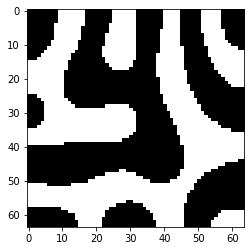

In [3]:
# visualize an image from dataset
img = g.reshape(37523,64,64)
plt.imshow(img[9,:,:], interpolation='nearest', cmap='binary')
plt.show()

In [4]:
# normalize the strain energy values
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
e_scaled = scaler.fit_transform(e[:,6].reshape(-1, 1))
e_scaled.shape, e_scaled.ravel().shape

images = g.reshape((37523,64,64))
energies = e_scaled.ravel()

images.shape, energies.shape

((37523, 64, 64), (37523,))

In [5]:
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import random_split
from torch.utils.data import DataLoader

class CustomDataset(Dataset):
  def __init__(self, imgs, labels, transform):
    self.labels = labels
    self.imgs = imgs
    self.transform = transform

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, index):
    x = self.imgs[index]
    x = self.transform(x)
    y = self.labels[index]
    return x, y

b, w, h, = [*images.shape]
print(images.shape)
images_wb = np.repeat(images[..., np.newaxis], 1, -1)
print(images_wb.shape)
images_wb = images_wb.reshape(b, 1, w, h)
print(images_wb.shape)

(37523, 64, 64)
(37523, 64, 64, 1)
(37523, 1, 64, 64)


In [6]:
transform = transforms.Compose([
      # transforms.Resize((32, 32)),
        ])

# Datasets
normalized_images = images_wb
data = torch.tensor(normalized_images, dtype=torch.float32)
target = torch.tensor(energies, dtype=torch.float32).reshape(-1,1)

if __name__ == "__main__":
  dataset = CustomDataset(data, target, transform)

In [7]:
# train-test split
train_set_size = int(len(dataset)*0.8)
val_set_size = len(dataset) - train_set_size

trainset, valset  = random_split(dataset, [train_set_size, val_set_size])
batch_size = 64
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers= 2)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers= 2)

# Model

In [82]:
kernel_size = 4
init_channels = 8
image_channels = 1
latent_dim = 16

class ConvVAE(nn.Module):
    def __init__(self):
        super(ConvVAE, self).__init__()
 
        # encoder
        self.enc1 = nn.Conv2d(in_channels=image_channels, out_channels=init_channels*2, kernel_size=kernel_size, 
            stride=2, padding=1)
        self.enc2 = nn.Conv2d(in_channels=init_channels*2, out_channels=init_channels*4, kernel_size=kernel_size, 
            stride=2, padding=1)
        self.enc3 = nn.Conv2d(in_channels=init_channels*4, out_channels=init_channels*4, kernel_size=kernel_size, 
            stride=2, padding=1)
        self.enc4 = nn.Conv2d(in_channels=init_channels*4, out_channels=64, kernel_size=kernel_size, 
            stride=2, padding=0)
        # fully connected layers for learning representations
        self.fc1 = nn.Linear(64, 128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_log_var = nn.Linear(128, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 64)
        # decoder 
        self.dec1 = nn.ConvTranspose2d(in_channels=64, out_channels=init_channels*8, kernel_size=kernel_size, 
            stride=1, padding=0)
        self.dec2 = nn.ConvTranspose2d(in_channels=init_channels*8, out_channels=init_channels*8, kernel_size=kernel_size, 
            stride=2, padding=1)
        self.dec3 = nn.ConvTranspose2d(in_channels=init_channels*8, out_channels=init_channels*4, kernel_size=kernel_size, 
            stride=2, padding=1)
        self.dec4 = nn.ConvTranspose2d(in_channels=init_channels*4, out_channels=init_channels*2, kernel_size=kernel_size, 
            stride=2, padding=1)
        self.dec5 = nn.ConvTranspose2d(in_channels=init_channels*2, out_channels=image_channels, kernel_size=kernel_size, 
            stride=2, padding=1)
    def encoder(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        batch, _, _, _ = x.shape
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        hidden = self.fc1(x)
        return hidden

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # 'randn_like' as we need the same size
        sample = mu + (eps * std) # sampling
        return sample

    def decoder(self,z):
        x = F.relu(self.dec1(z))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        reconstruction = torch.sigmoid(self.dec5(x))
        return reconstruction
 
    def forward(self, x):
        hidden = self.encoder(x)
        # get 'mu' and 'log_var'
        mu = self.fc_mu(hidden)
        log_var = self.fc_log_var(hidden)
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        x = self.fc2(z)
        x = x.view(-1, 64, 1, 1)
        out = self.decoder(x)
        return z, mu, log_var, out

In [83]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# initialize the model
model = ConvVAE().to(device)
# set the learning parameters
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.MSELoss(reduction='mean')

In [84]:
from tqdm import tqdm

torch.backends.cudnn.benchmark = True

def final_loss(mse_loss, beta, mu, logvar):
    BCE = mse_loss 
    KLD = torch.mean(-0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim = 1), dim = 0)
    return BCE + beta*KLD

def train(dataloader, dataset, beta):
    model.train()
    running_loss = 0.0
    counter = 0
    for i, (data,target) in tqdm(enumerate(dataloader)):
        counter += 1
        data = data.to(device)
        optimizer.zero_grad(set_to_none=True)

        z, mu, logvar, out = model(data)
        bce_loss = criterion(out, data)
        loss = final_loss(bce_loss, beta, mu, logvar)

        loss.backward()
        running_loss += loss.item()
        optimizer.step()
    train_loss = running_loss / counter 
    return z, train_loss

def validate(dataloader, dataset, beta):
    model.eval()
    running_loss = 0.0
    counter = 0
    with torch.no_grad():
        for i, (data,target) in tqdm(enumerate(dataloader)):
            counter += 1
            data = data.to(device)
            z, mu, logvar, out = model(data)
            bce_loss = criterion(out, data)
            loss = final_loss(bce_loss, beta, mu, logvar)
            running_loss += loss.item()
        
    val_loss = running_loss / counter
    return z, val_loss

In [66]:
epochs = 100

train_loss = []
valid_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    # beta annealing
    if epoch<30:
      beta=0
    else:
      beta=1e-3

    ztrain, train_epoch_loss = train(trainloader, trainset, beta)
    zval, valid_epoch_loss = validate(valloader, valset, beta)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)

    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {valid_epoch_loss:.4f}")

Epoch 1 of 100


470it [00:06, 77.82it/s]
118it [00:00, 179.31it/s]

Train Loss: 0.2190
Val Loss: 0.1894
Epoch 2 of 100



470it [00:06, 77.00it/s]
118it [00:00, 121.33it/s]

Train Loss: 0.1549
Val Loss: 0.1501
Epoch 3 of 100



470it [00:05, 87.22it/s]
118it [00:00, 182.96it/s]

Train Loss: 0.1191
Val Loss: 0.1145
Epoch 4 of 100



470it [00:05, 86.47it/s]
118it [00:00, 185.79it/s]

Train Loss: 0.1011
Val Loss: 0.1013
Epoch 5 of 100



470it [00:05, 87.21it/s]
118it [00:00, 180.59it/s]

Train Loss: 0.0904
Val Loss: 0.1070
Epoch 6 of 100



470it [00:05, 87.27it/s]
118it [00:00, 177.53it/s]

Train Loss: 0.0835
Val Loss: 0.0858
Epoch 7 of 100



470it [00:05, 87.35it/s]
118it [00:00, 182.79it/s]

Train Loss: 0.0775
Val Loss: 0.0866
Epoch 8 of 100



470it [00:05, 87.80it/s]
118it [00:00, 184.33it/s]

Train Loss: 0.0740
Val Loss: 0.0828
Epoch 9 of 100



470it [00:06, 75.46it/s]
118it [00:00, 184.81it/s]

Train Loss: 0.0713
Val Loss: 0.0748
Epoch 10 of 100



470it [00:05, 88.36it/s]
118it [00:00, 179.32it/s]

Train Loss: 0.0685
Val Loss: 0.0763
Epoch 11 of 100



470it [00:05, 88.18it/s]
118it [00:00, 182.42it/s]

Train Loss: 0.0667
Val Loss: 0.0751
Epoch 12 of 100



470it [00:05, 88.49it/s]
118it [00:00, 180.95it/s]

Train Loss: 0.0649
Val Loss: 0.0722
Epoch 13 of 100



470it [00:05, 88.14it/s]
118it [00:00, 181.77it/s]

Train Loss: 0.0635
Val Loss: 0.0693
Epoch 14 of 100



470it [00:05, 88.43it/s]
118it [00:00, 189.92it/s]

Train Loss: 0.0618
Val Loss: 0.0677
Epoch 15 of 100



470it [00:05, 86.58it/s]
118it [00:00, 177.14it/s]

Train Loss: 0.0609
Val Loss: 0.0685
Epoch 16 of 100



470it [00:06, 74.58it/s]
118it [00:00, 186.29it/s]

Train Loss: 0.0597
Val Loss: 0.0722
Epoch 17 of 100



470it [00:05, 88.08it/s]
118it [00:00, 179.58it/s]

Train Loss: 0.0592
Val Loss: 0.0698
Epoch 18 of 100



470it [00:05, 87.93it/s]
118it [00:00, 178.17it/s]

Train Loss: 0.0582
Val Loss: 0.0683
Epoch 19 of 100



470it [00:05, 89.00it/s]
118it [00:00, 179.16it/s]

Train Loss: 0.0575
Val Loss: 0.0654
Epoch 20 of 100



470it [00:05, 87.62it/s]
118it [00:00, 181.98it/s]

Train Loss: 0.0566
Val Loss: 0.0678
Epoch 21 of 100



470it [00:06, 74.48it/s]
118it [00:00, 182.65it/s]

Train Loss: 0.0559
Val Loss: 0.0680
Epoch 22 of 100



470it [00:05, 80.19it/s]
118it [00:01, 114.48it/s]

Train Loss: 0.0554
Val Loss: 0.0666
Epoch 23 of 100



470it [00:05, 85.42it/s]
118it [00:00, 177.31it/s]

Train Loss: 0.0551
Val Loss: 0.0617
Epoch 24 of 100



470it [00:05, 87.42it/s]
118it [00:00, 177.11it/s]

Train Loss: 0.0540
Val Loss: 0.0713
Epoch 25 of 100



470it [00:05, 87.35it/s]
118it [00:00, 187.14it/s]

Train Loss: 0.0539
Val Loss: 0.0649
Epoch 26 of 100



470it [00:05, 87.18it/s]
118it [00:00, 179.97it/s]

Train Loss: 0.0530
Val Loss: 0.0629
Epoch 27 of 100



470it [00:05, 87.38it/s]
118it [00:00, 175.27it/s]

Train Loss: 0.0527
Val Loss: 0.0650
Epoch 28 of 100



470it [00:05, 87.65it/s]
118it [00:00, 184.48it/s]

Train Loss: 0.0523
Val Loss: 0.0609
Epoch 29 of 100



470it [00:06, 75.51it/s]
118it [00:00, 183.45it/s]

Train Loss: 0.0516
Val Loss: 0.0636
Epoch 30 of 100



470it [00:05, 87.35it/s]
118it [00:00, 177.57it/s]

Train Loss: 0.0514
Val Loss: 0.0583
Epoch 31 of 100



470it [00:05, 88.88it/s]
118it [00:00, 181.15it/s]

Train Loss: 0.1010
Val Loss: 0.1058
Epoch 32 of 100



470it [00:05, 87.84it/s]
118it [00:00, 181.52it/s]

Train Loss: 0.0983
Val Loss: 0.1040
Epoch 33 of 100



470it [00:05, 87.27it/s]
118it [00:00, 173.43it/s]

Train Loss: 0.0976
Val Loss: 0.1035
Epoch 34 of 100



470it [00:05, 87.32it/s]
118it [00:00, 180.05it/s]

Train Loss: 0.0973
Val Loss: 0.1041
Epoch 35 of 100



470it [00:05, 87.15it/s]
118it [00:00, 170.14it/s]

Train Loss: 0.0972
Val Loss: 0.1058
Epoch 36 of 100



470it [00:06, 74.47it/s]
118it [00:00, 187.54it/s]

Train Loss: 0.0971
Val Loss: 0.1025
Epoch 37 of 100



470it [00:05, 86.54it/s]
118it [00:00, 180.99it/s]

Train Loss: 0.0963
Val Loss: 0.1047
Epoch 38 of 100



470it [00:05, 87.36it/s]
118it [00:00, 178.03it/s]

Train Loss: 0.0964
Val Loss: 0.1018
Epoch 39 of 100



470it [00:05, 88.37it/s]
118it [00:00, 181.64it/s]

Train Loss: 0.0960
Val Loss: 0.1053
Epoch 40 of 100



470it [00:05, 87.80it/s]
118it [00:00, 178.39it/s]

Train Loss: 0.0959
Val Loss: 0.1024
Epoch 41 of 100



470it [00:05, 88.19it/s]
118it [00:00, 171.40it/s]

Train Loss: 0.0956
Val Loss: 0.1036
Epoch 42 of 100



470it [00:05, 86.85it/s]
118it [00:00, 186.32it/s]

Train Loss: 0.0952
Val Loss: 0.1017
Epoch 43 of 100



470it [00:06, 74.36it/s]
118it [00:00, 177.69it/s]

Train Loss: 0.0950
Val Loss: 0.1021
Epoch 44 of 100



470it [00:05, 87.97it/s]
118it [00:00, 181.10it/s]

Train Loss: 0.0948
Val Loss: 0.1066
Epoch 45 of 100



470it [00:05, 87.46it/s]
118it [00:00, 182.87it/s]

Train Loss: 0.0948
Val Loss: 0.1039
Epoch 46 of 100



470it [00:05, 86.41it/s]
118it [00:00, 182.33it/s]

Train Loss: 0.0945
Val Loss: 0.0993
Epoch 47 of 100



470it [00:05, 87.29it/s]
118it [00:00, 173.16it/s]

Train Loss: 0.0940
Val Loss: 0.1034
Epoch 48 of 100



470it [00:05, 86.69it/s]
118it [00:00, 178.94it/s]

Train Loss: 0.0939
Val Loss: 0.1055
Epoch 49 of 100



470it [00:05, 83.43it/s]
118it [00:01, 114.90it/s]

Train Loss: 0.0942
Val Loss: 0.1003
Epoch 50 of 100



470it [00:05, 82.40it/s]
118it [00:00, 181.57it/s]

Train Loss: 0.0935
Val Loss: 0.1022
Epoch 51 of 100



470it [00:05, 86.04it/s]
118it [00:00, 182.34it/s]

Train Loss: 0.0935
Val Loss: 0.1002
Epoch 52 of 100



470it [00:05, 85.78it/s]
118it [00:00, 175.04it/s]

Train Loss: 0.0933
Val Loss: 0.0997
Epoch 53 of 100



470it [00:05, 86.25it/s]
118it [00:00, 181.57it/s]

Train Loss: 0.0928
Val Loss: 0.0991
Epoch 54 of 100



470it [00:05, 85.79it/s]
118it [00:00, 180.83it/s]

Train Loss: 0.0928
Val Loss: 0.0989
Epoch 55 of 100



470it [00:05, 86.55it/s]
118it [00:00, 181.67it/s]

Train Loss: 0.0924
Val Loss: 0.1001
Epoch 56 of 100



470it [00:05, 87.80it/s]
118it [00:00, 177.40it/s]

Train Loss: 0.0922
Val Loss: 0.0977
Epoch 57 of 100



470it [00:05, 87.02it/s]
118it [00:00, 182.46it/s]

Train Loss: 0.0921
Val Loss: 0.1000
Epoch 58 of 100



470it [00:06, 77.41it/s]
118it [00:00, 131.00it/s]

Train Loss: 0.0921
Val Loss: 0.0988
Epoch 59 of 100



470it [00:05, 86.61it/s]
118it [00:00, 183.06it/s]

Train Loss: 0.0919
Val Loss: 0.1029
Epoch 60 of 100



470it [00:05, 85.98it/s]
118it [00:00, 181.27it/s]

Train Loss: 0.0919
Val Loss: 0.0968
Epoch 61 of 100



470it [00:05, 86.69it/s]
118it [00:00, 175.92it/s]

Train Loss: 0.0914
Val Loss: 0.1010
Epoch 62 of 100



470it [00:05, 86.83it/s]
118it [00:00, 181.54it/s]

Train Loss: 0.0915
Val Loss: 0.0997
Epoch 63 of 100



470it [00:05, 87.43it/s]
118it [00:00, 180.39it/s]

Train Loss: 0.0914
Val Loss: 0.0995
Epoch 64 of 100



470it [00:05, 88.83it/s]
118it [00:00, 181.89it/s]

Train Loss: 0.0910
Val Loss: 0.0980
Epoch 65 of 100



470it [00:05, 86.07it/s]
118it [00:00, 175.33it/s]

Train Loss: 0.0908
Val Loss: 0.0975
Epoch 66 of 100



470it [00:05, 87.06it/s]
118it [00:00, 177.54it/s]

Train Loss: 0.0905
Val Loss: 0.0970
Epoch 67 of 100



470it [00:05, 87.59it/s]
118it [00:00, 180.66it/s]

Train Loss: 0.0904
Val Loss: 0.0963
Epoch 68 of 100



470it [00:05, 87.80it/s]
118it [00:00, 181.69it/s]

Train Loss: 0.0904
Val Loss: 0.0973
Epoch 69 of 100



470it [00:05, 88.21it/s]
118it [00:00, 178.26it/s]

Train Loss: 0.0906
Val Loss: 0.0979
Epoch 70 of 100



470it [00:05, 86.33it/s]
118it [00:00, 179.61it/s]

Train Loss: 0.0903
Val Loss: 0.0996
Epoch 71 of 100



470it [00:05, 87.41it/s]
118it [00:00, 180.54it/s]

Train Loss: 0.0902
Val Loss: 0.0969
Epoch 72 of 100



470it [00:05, 81.21it/s]
118it [00:01, 113.58it/s]

Train Loss: 0.0898
Val Loss: 0.0972
Epoch 73 of 100



470it [00:05, 84.29it/s]
118it [00:00, 184.04it/s]

Train Loss: 0.0898
Val Loss: 0.0966
Epoch 74 of 100



470it [00:05, 86.34it/s]
118it [00:00, 181.45it/s]

Train Loss: 0.0898
Val Loss: 0.0990
Epoch 75 of 100



470it [00:05, 87.14it/s]
118it [00:00, 176.39it/s]

Train Loss: 0.0896
Val Loss: 0.0961
Epoch 76 of 100



470it [00:06, 74.72it/s]
118it [00:00, 182.23it/s]

Train Loss: 0.0893
Val Loss: 0.0967
Epoch 77 of 100



470it [00:05, 88.17it/s]
118it [00:00, 169.64it/s]

Train Loss: 0.0894
Val Loss: 0.0993
Epoch 78 of 100



470it [00:05, 82.91it/s]
118it [00:01, 114.57it/s]

Train Loss: 0.0894
Val Loss: 0.0958
Epoch 79 of 100



470it [00:05, 80.02it/s]
118it [00:00, 171.46it/s]

Train Loss: 0.0893
Val Loss: 0.0985
Epoch 80 of 100



470it [00:05, 87.43it/s]
118it [00:00, 180.54it/s]

Train Loss: 0.0892
Val Loss: 0.0961
Epoch 81 of 100



470it [00:05, 87.53it/s]
118it [00:00, 181.05it/s]

Train Loss: 0.0890
Val Loss: 0.0969
Epoch 82 of 100



470it [00:05, 87.06it/s]
118it [00:00, 176.72it/s]

Train Loss: 0.0890
Val Loss: 0.0970
Epoch 83 of 100



470it [00:05, 85.27it/s]
118it [00:00, 181.90it/s]

Train Loss: 0.0887
Val Loss: 0.0967
Epoch 84 of 100



470it [00:06, 73.90it/s]
118it [00:00, 173.66it/s]

Train Loss: 0.0886
Val Loss: 0.0950
Epoch 85 of 100



470it [00:05, 87.32it/s]
118it [00:00, 183.44it/s]

Train Loss: 0.0885
Val Loss: 0.0953
Epoch 86 of 100



470it [00:05, 87.17it/s]
118it [00:00, 179.89it/s]

Train Loss: 0.0884
Val Loss: 0.0960
Epoch 87 of 100



470it [00:05, 87.17it/s]
118it [00:00, 184.65it/s]

Train Loss: 0.0886
Val Loss: 0.0970
Epoch 88 of 100



470it [00:05, 84.69it/s]
118it [00:00, 175.87it/s]

Train Loss: 0.0884
Val Loss: 0.0945
Epoch 89 of 100



470it [00:05, 86.50it/s]
118it [00:00, 175.83it/s]

Train Loss: 0.0880
Val Loss: 0.1007
Epoch 90 of 100



470it [00:06, 73.18it/s]
118it [00:00, 181.16it/s]

Train Loss: 0.0881
Val Loss: 0.0958
Epoch 91 of 100



470it [00:05, 88.61it/s]
118it [00:00, 181.38it/s]

Train Loss: 0.0878
Val Loss: 0.0957
Epoch 92 of 100



470it [00:05, 86.55it/s]
118it [00:00, 168.67it/s]

Train Loss: 0.0879
Val Loss: 0.0944
Epoch 93 of 100



470it [00:05, 87.06it/s]
118it [00:00, 178.19it/s]

Train Loss: 0.0878
Val Loss: 0.0948
Epoch 94 of 100



470it [00:05, 86.56it/s]
118it [00:00, 181.79it/s]

Train Loss: 0.0877
Val Loss: 0.0964
Epoch 95 of 100



470it [00:05, 87.36it/s]
118it [00:00, 186.83it/s]

Train Loss: 0.0878
Val Loss: 0.0954
Epoch 96 of 100



470it [00:06, 75.98it/s]
118it [00:00, 171.37it/s]

Train Loss: 0.0877
Val Loss: 0.0960
Epoch 97 of 100



470it [00:05, 85.27it/s]
118it [00:00, 174.72it/s]

Train Loss: 0.0877
Val Loss: 0.0954
Epoch 98 of 100



470it [00:05, 87.17it/s]
118it [00:00, 177.20it/s]

Train Loss: 0.0872
Val Loss: 0.0953
Epoch 99 of 100



470it [00:05, 86.77it/s]
118it [00:00, 175.01it/s]

Train Loss: 0.0874
Val Loss: 0.0945
Epoch 100 of 100



470it [00:05, 86.52it/s]
118it [00:00, 176.06it/s]

Train Loss: 0.0871
Val Loss: 0.0958


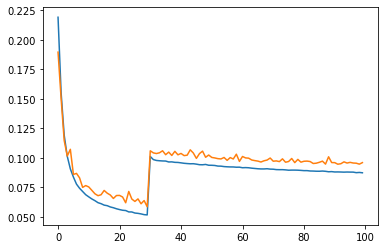

In [67]:
fig, ax = plt.subplots()
ax.plot(train_loss, label='Train loss')
ax.plot(valid_loss, label='Validation loss')

In [ ]:
# save model
import os
PATH = '/content/drive/MyDrive/'
# torch.save(model, PATH+'mech_MNIST_ls16')

model_scripted = torch.jit.script(model.cpu())
model_scripted.save(os.path.join(PATH, f'mech_MNIST_ls16-scripted.pt'))
torch.save(model.state_dict(), PATH)

In [ ]:
# load trained model
PATH = '/content/drive/MyDrive/'
model = torch.load(PATH+'mech_MNIST_ls16')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Reconstructed Images

In [87]:
original_images = []
reconstructed_images = []
z_train = np.zeros((0,16))
strain_energy = np.zeros((0,1))
for i, (d,t) in tqdm(enumerate(trainloader)):
  d = d.to(device)
  z, _, _, out = model(d)
  original_images.append(d.cpu().detach().numpy())
  reconstructed_images.append(out.cpu().detach().numpy())
  z_train = np.vstack([z_train,z.cpu().detach().numpy()])
  strain_energy = np.vstack([strain_energy, t.cpu().detach().numpy()])
strain_energy = strain_energy.ravel()

470it [00:05, 93.74it/s] 


Text(-10, 52, 'Reconstruction')

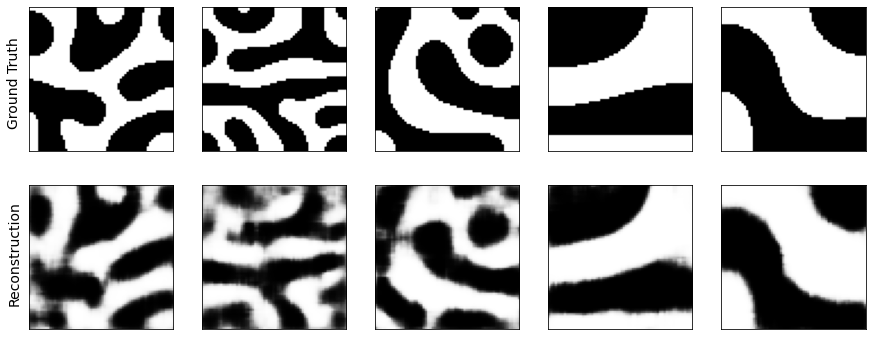

In [81]:
f, axs = plt.subplots(2,5, figsize=(15,6))
for i, ind in enumerate(np.random.randint(0,64,5)):
  axs[0,i].imshow(original_images[0].reshape(64,64,64)[ind,:,:], 
                  norm=plt.Normalize(0,1), cmap="Greys")
  axs[0,i].axes.xaxis.set_visible(False)
  axs[0,i].axes.yaxis.set_visible(False)
  axs[1,i].imshow(reconstructed_images[0].reshape(64,64,64)[ind,:,:], norm=plt.Normalize(0,1), cmap="Greys")
  axs[1,i].axes.xaxis.set_visible(False)
  axs[1,i].axes.yaxis.set_visible(False)

axs[0,0].text(-10, 52, 'Ground Truth', fontsize=14, rotation=90)
axs[1,0].text(-10, 52, 'Reconstruction', fontsize=14, rotation=90)

# Latent Space

In [88]:
# decrease the dimensionality of latent space from 16 to 2 to visualize
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
z_projected = pca.fit_transform(z_train)

z_train_labels = [e[indx,6] for indx in trainset.indices]

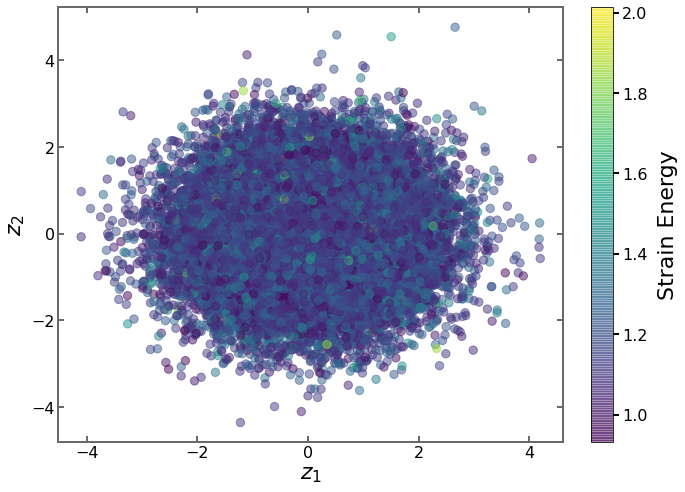

In [89]:
z = z_projected

fig, ax = plt.subplots(figsize=(10, 8))
font_size=22
tick_size=16

sc = ax.scatter(*z.T, s=70, c=z_train_labels, cmap='viridis', alpha=0.5)

ax.set_xlabel("$z_{1}$", fontsize=font_size)
ax.set_ylabel("$z_{2}$", fontsize=font_size)

plt.setp(ax.spines.values(), linewidth=2, color='dimgrey')
ax.xaxis.set_tick_params(width=2, color='dimgrey')
ax.yaxis.set_tick_params(width=2, color='dimgrey')
ax.tick_params(direction='in', length=6, labelsize=tick_size, 
              top=True, right=True)

cbar = plt.colorbar(sc,fraction=0.045, pad=0.05)
cbar.set_label(label='Strain Energy', labelpad=10, size=font_size)
cbar.ax.tick_params(length=6, width=2,labelsize=tick_size)

In [92]:
import plotly.graph_objects as go

z = z_projected

fig = go.Figure(data=[go.Scatter(
                                  x = z[:,0], 
                                  y = z[:,1],
                                  mode = 'markers',
                                  marker = dict(color= z_train_labels,
                                                colorscale='Viridis', 
                                                size=12, 
                                                opacity=0.5, 
                                                colorbar=dict(thickness=12)))
])
fig.update_layout(height=500, width=600, showlegend=False, 
                  margin=dict(l=70,r=50,b=70,t=50),
                  xaxis_title="$z_{1}$",
                  yaxis_title="$z_{2}$",
                       font=dict(
                           size=14
                           )
                  )
fig.show()

In [ ]:
imgs_train = [g[indx] for indx in trainset.indices]
e_train = [e[indx,6] for indx in trainset.indices]

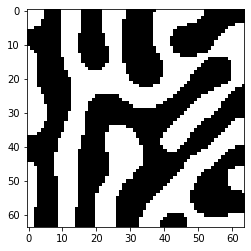

In [ ]:
indx = np.argmin(np.linalg.norm(z - np.array([4.58,-1.047]), axis=1))
fig,ax = plt.subplots()
ax.imshow(imgs_train[indx].reshape(64,64), interpolation='nearest', cmap='binary')

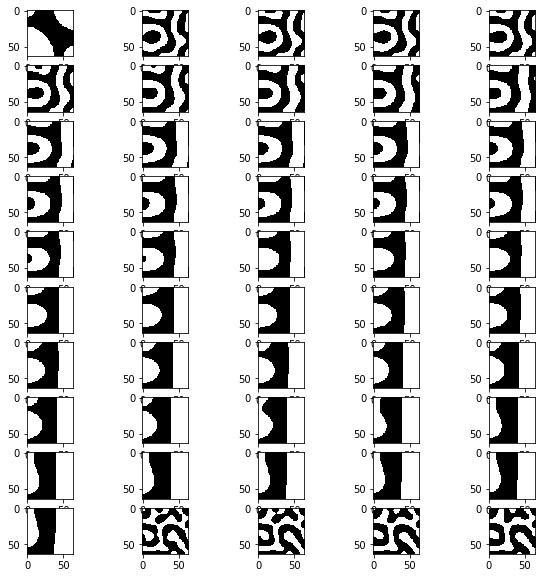

In [ ]:
indx_list = np.linspace(1,10,10,dtype=int)
geo = g.reshape(37523,64,64)

plt.figure(figsize=(10,10)) # specifying the overall grid size

for i in range(50):
    plt.subplot(10,5,i+1)    # the number of images in the grid is 5*5 (25)
    plt.imshow(geo[i+290,:,:], interpolation='nearest', cmap='binary')
plt.show()

In [ ]:
for i in range(1,42,5):
  print(i)

1
6
11
16
21
26
31
36
41
